# TP3 : Lazy training


Observing the lazy training regime with different models

With inspiration from

https://rajatvd.github.io/NTK/

In [2]:
import torch

import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt

In [3]:
### Exectutes the script tp3_utils.py which contains code from last time
## Go take a quick look at the functions implemented there

from tp3_utils import *

# %load_ext autoreload
# %autoreload 2

## The data

We continue with last week's toy problem of 1 dimensional regression

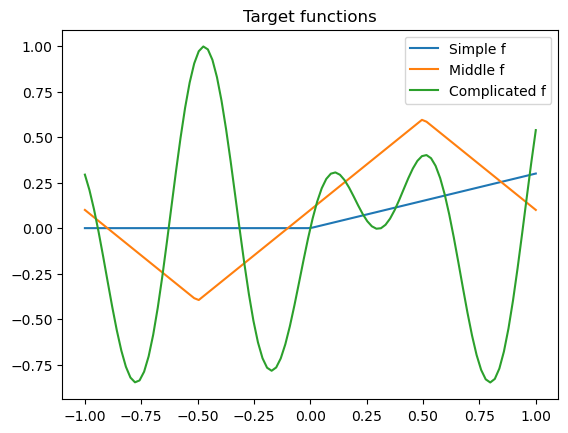

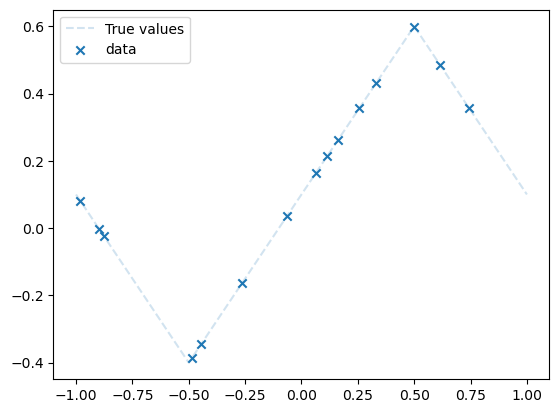

In [4]:
xs = np.linspace(-1, 1, 100)
plt.plot(xs, simple_f(xs), label="Simple f")
plt.plot(xs, middle_f(xs), label="Middle f")
plt.plot(xs, complex_f(xs), label="Complicated f")
plt.title("Target functions")
plt.legend()
plt.show()

dataset = Data(n=15, xmin=-1, xmax=1, noise_level=0, type="middle")

plot_data(dataset)
plt.legend()
plt.show()

## The training function

Write the training function

In [5]:
def train(net, dataset, N_steps=1, batch_size=30, lr=0.01, save_weights_every=100):
    optimizer = optim.SGD(net.parameters(), lr=lr)
    criterion = nn.MSELoss()

    losses = []
    weights = []

    for i in range(N_steps):
        inputs, labels = dataset.next_batch(batch_size)
        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        losses.append(loss.detach().numpy())

        if i % save_weights_every == 0 and (save_weights_every > 0):
            with torch.no_grad():
                weights.append(net.save_weights())

    return losses

In [ ]:
def train(net, dataset, N_steps=1, batch_size=30, lr=0.01, save_weights_every=100):
    # YOUR CODE HERE

    losses = []
    weights = []

    for i in range(N_steps):
        # YOUR CODE HERE

        losses.append(loss.detach().numpy())

        if i % save_weights_every == 0 and (save_weights_every > 0):
            with torch.no_grad():
                weights.append(net.save_weights())

    return losses

## Test your training

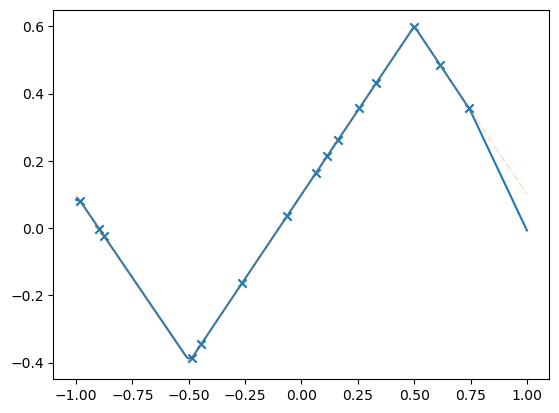

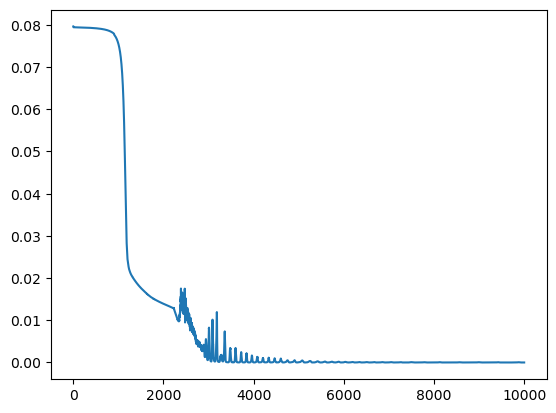

In [6]:
model = MLPdeep(hidden_dim=10)
losses = train(
    model,
    dataset,
    N_steps=10000,
    batch_size=15,
    lr=0.1,
    save_weights_every=1,
)

plot_net(model)
plot_data(dataset)
plt.show()

plt.plot(losses)
plt.show()

# A linear model

We define a family of linear models with sinusoidal features. 
The feature map is 

$$
    \phi(x) = ( \cos(2 \pi x) , \sin(2 \pi x), \cos(4 \pi x) , \sin(4 \pi x), \dots ,  \cos(2k \pi x) , \sin(2k \pi x))
$$
where $k$ is feature_dim / 2. 

In [7]:
class LinSin(nn.Module):
    """
    A linear model with sinusoidal features. Assumes feature_dim is even.
    """

    def __init__(self, feature_dim):
        super().__init__()
        self.feature_dim = feature_dim
        self.lout = nn.Linear(self.feature_dim, 1)

        self.weight_history = []

    def phi(self, x):
        """
        Computes $sin(2\pi k x), cos(2\pi k x) $ for k in $[feature_dim / 2]$
        """
        r = 2 * np.pi * torch.arange(int(self.feature_dim / 2)) * x
        return torch.concatenate([torch.sin(r), torch.cos(r)], axis=1)

    def save_weights(self):
        with torch.no_grad():
            l = list(self.parameters())
            self.weight_history.append(np.copy(l[-1].numpy()))

    def forward(self, x):
        return self.lout(self.phi(x))

In [ ]:
class LinSin(nn.Module):
    """
    A linear model with sinusoidal features
    """

    def __init__(self, feature_dim):
        super().__init__()
        self.feature_dim = feature_dim
        self.lout = nn.Linear(self.feature_dim, 1)

        self.weight_history = []

    def phi(self, x):
        """
        Computes $sin(2\pi k x), cos(2\pi k x) $ for k in $[feature_dim / 2]$
        """
        # YOUR CODE HERE
        pass

    def save_weights(self):
        with torch.no_grad():
            l = list(self.parameters())
            self.weight_history.append(np.copy(l[-1].numpy()))

    def forward(self, x):
        # YOUR CODE HERE
        pass

Test the linear model

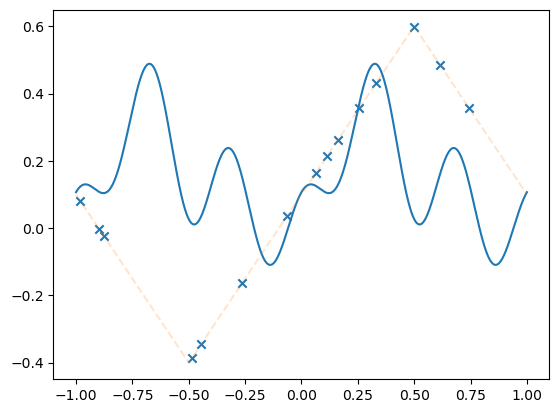

Text(0.5, 1.0, 'Relative weight movement of last layer')

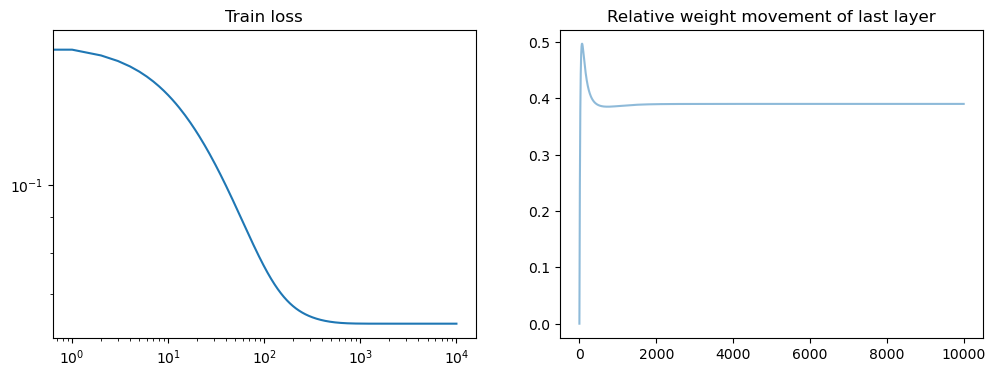

In [15]:
model = LinSin(feature_dim=8)
losses = train(
    model,
    dataset,
    N_steps=10000,
    batch_size=15,
    lr=0.01,
    save_weights_every=1,
)

plot_net(model)
plot_data(dataset)
plt.show()

fig, axs = plt.subplots(1, 2, figsize=(12, 4))
axs[0].loglog(losses)
axs[0].set_title("Train loss")

all_weights1 = np.array(model.weight_history)
weight_evol = np.linalg.norm(all_weights1 - all_weights1[0], axis=1) / np.linalg.norm(
    all_weights1[0]
)
axs[1].plot(weight_evol, alpha=0.5)
axs[1].set_title("Relative weight movement of last layer")

**Question**: what do the plots mean?

Let us now repeat the code above with a large feature dimension. What you do observe? 

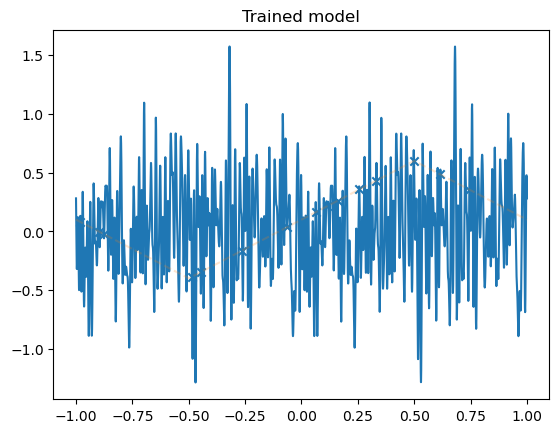

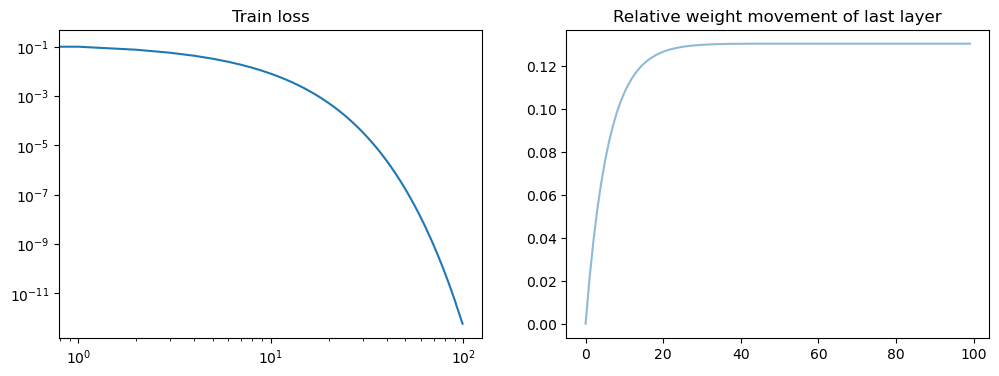

In [16]:
model = LinSin(feature_dim=200)
losses = train(
    model,
    dataset,
    N_steps=100,
    batch_size=15,
    lr=0.01,
    save_weights_every=1,
)

plot_net(model)
plot_data(dataset)
plt.title("Trained model")
plt.show()

fig, axs = plt.subplots(1, 2, figsize=(12, 4))
axs[0].loglog(losses)
axs[0].set_title("Train loss")

all_weights1 = np.array(model.weight_history)
weight_evol = np.linalg.norm(all_weights1 - all_weights1[0], axis=1) / np.linalg.norm(
    all_weights1[0]
)
axs[1].plot(weight_evol, alpha=0.5)
axs[1].set_title("Relative weight movement of last layer")

plt.show()

## Robustness of fast convergence for linear models

Run 10 instances of the linear model with different initializations. 

Are there significant differences between the models? 

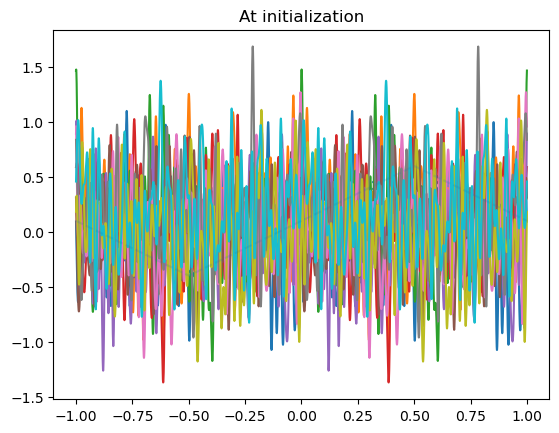

In [17]:
model_list = []
N_models = 10
for _ in range(N_models):
    model = LinSin(feature_dim=100)
    model_list.append(model)
    plot_net(model)

plot_data(dataset)
plt.title("At initialization")

all_losses = [[] for _ in range(N_models)]
all_weights = []

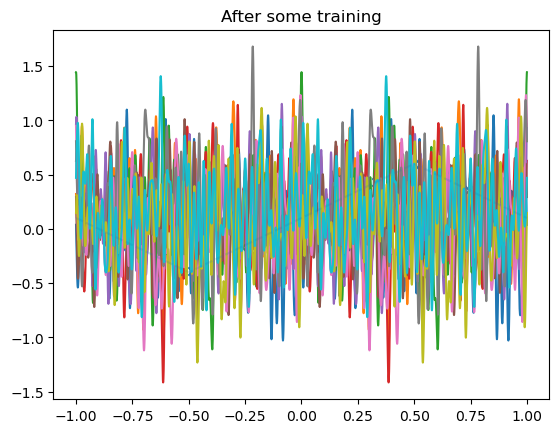

In [18]:
N_steps = 10000

for i, model in enumerate(model_list):
    losses = train(
        model,
        dataset,
        N_steps=N_steps,
        batch_size=15,
        lr=0.01,
        save_weights_every=1,
    )
    all_losses[i] += losses
    plot_net(model)

plot_data(dataset)
plt.title("After some training")

plt.show()

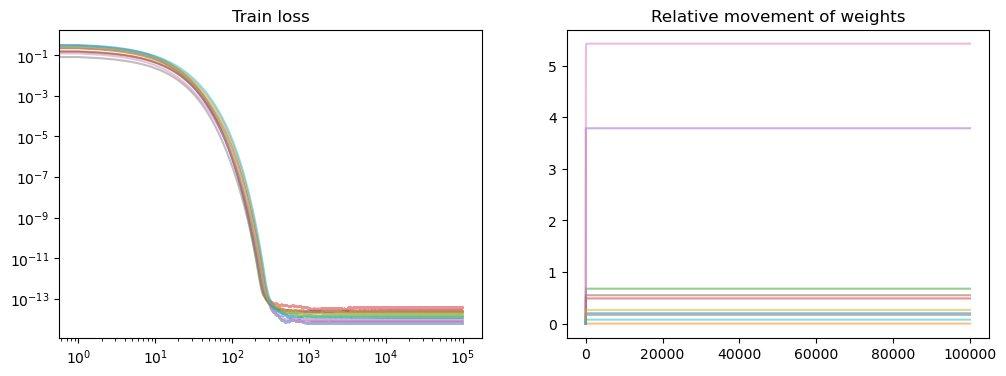

In [19]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

axs[0].set_title("Train loss")
for losses in all_losses:
    points = np.arange(0, len(losses), 1)
    losses = np.array(losses)
    axs[0].loglog(points, losses[points], alpha=0.5)

axs[1].set_title("Relative movement of weights")
for model in model_list:
    all_weights1 = np.array(model.weight_history)
    weight_evol = np.linalg.norm(
        all_weights1 - all_weights1[0], axis=1
    ) / np.linalg.norm(all_weights1[0])

    axs[1].plot(weight_evol, alpha=0.5)

plt.show()

# Lazy training of non-linear models

We now train some neural nets in different regimes and try to see when lazy training occurs. 

**Question** 
How are nets initialized in pytorch?

https://pytorch.org/docs/stable/generated/torch.nn.Linear.html

31


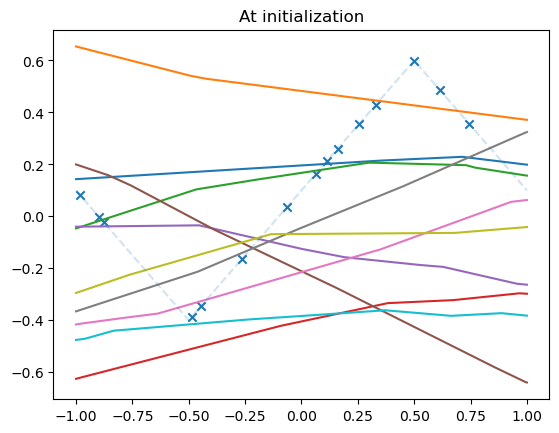

In [36]:
model_list = []
N_models = 10
for _ in range(N_models):
    model = MLPshallow(hidden_dim=10)
    model_list.append(model)
    plot_net(model)

plot_data(dataset)
plt.title("At initialization")

all_losses = [[] for _ in range(N_models)]
all_weights = []

print(sum([p.numel() for p in model.parameters()]))

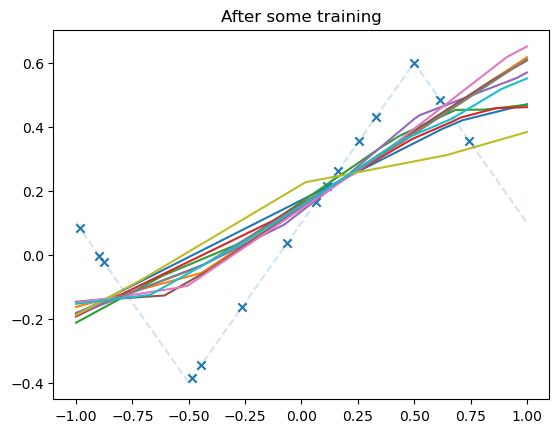

In [37]:
N_steps = 5000

for i, model in enumerate(model_list):
    losses = train(
        model,
        dataset,
        N_steps=N_steps,
        batch_size=30,
        lr=0.001,
        save_weights_every=1,
    )
    all_losses[i] += losses
    plot_net(model)

plot_data(dataset)
plt.title("After some training")

plt.show()

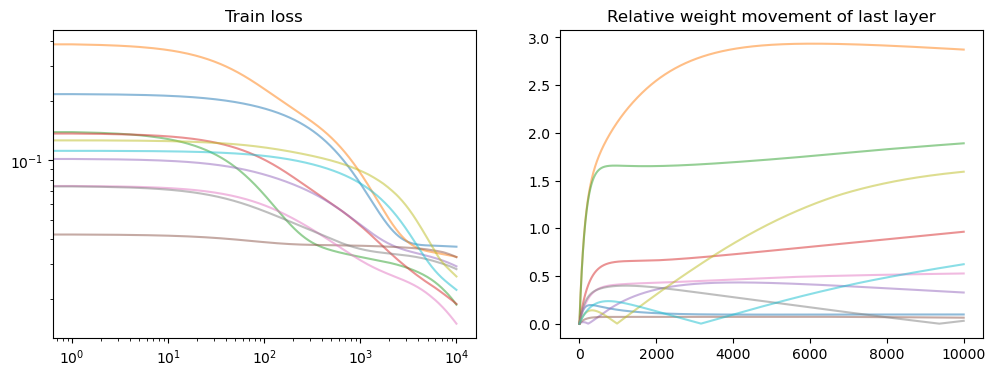

In [23]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

axs[0].set_title("Train loss")
for losses in all_losses:
    points = np.arange(0, len(losses), 1)
    losses = np.array(losses)
    axs[0].loglog(points, losses[points], alpha=0.5)

axs[1].set_title("Relative weight movement of last layer")
for model in model_list:
    all_weights1 = np.array(model.weight_history)
    weight_evol = np.linalg.norm(
        all_weights1 - all_weights1[0], axis=1
    ) / np.linalg.norm(all_weights1[0])

    axs[1].plot(weight_evol, alpha=0.5)

plt.show()

## Thin vs. Wide networks

Let us now vary the width of our network. What happens? 

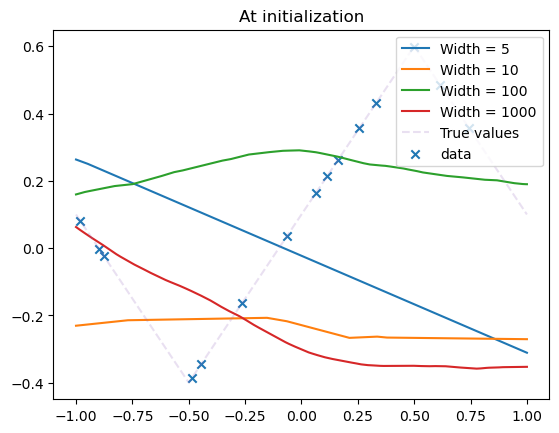

In [38]:
model_list = []

width_list = [5, 10, 100, 1000]

for width in width_list:
    model = MLPshallow(hidden_dim=width)
    model_list.append(model)
    plot_net(model, label=f"Width = {model.hidden_dim}")

plot_data(dataset)
plt.title("At initialization")
plt.legend()

all_losses = [[] for _ in width_list]
all_weights = []

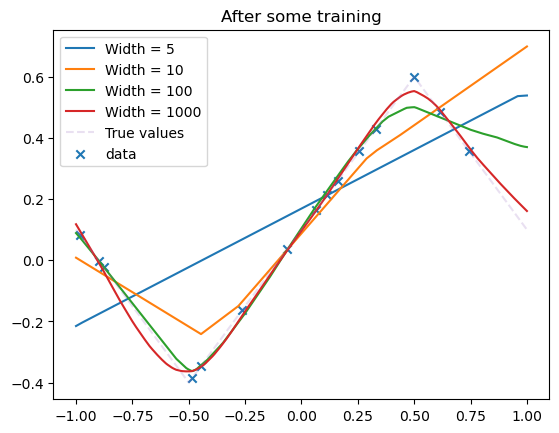

In [41]:
N_steps = 50000

for i, model in enumerate(model_list):
    losses = train(
        model,
        dataset,
        N_steps=N_steps,
        batch_size=15,
        lr=0.002,
        save_weights_every=1,
    )
    all_losses[i] += losses
    plot_net(model, label=f"Width = {model.hidden_dim}")

plot_data(dataset)
plt.title("After some training")
plt.legend()

plt.show()

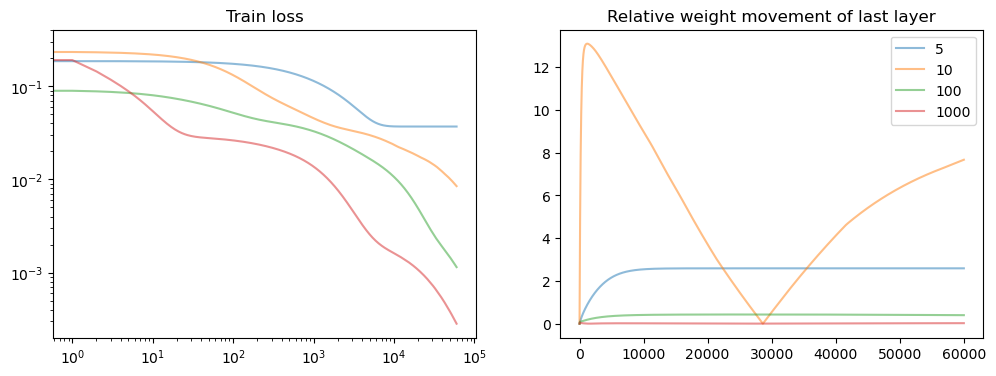

In [42]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

axs[0].set_title("Train loss")
for i, losses in enumerate(all_losses):
    points = np.arange(0, len(losses), 1)
    losses = np.array(losses)
    axs[0].loglog(points, losses[points], alpha=0.5, label=f"{width_list[i]}")

axs[1].set_title("Relative weight movement of last layer")
for model in model_list:
    all_weights1 = np.array(model.weight_history)
    weight_evol = np.linalg.norm(
        all_weights1 - all_weights1[0], axis=1
    ) / np.linalg.norm(all_weights1[0])

    axs[1].plot(weight_evol, alpha=0.5, label=f"{model.hidden_dim}")

plt.legend()
plt.show()

## Bad initialization can you get you out of the Lazy regime


We simulate bad initialization by taking two steps of gradient descent from initialization.

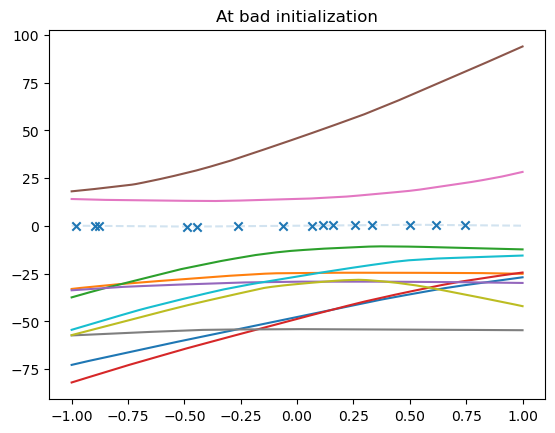

In [43]:
model_list = []
N_models = 10
for _ in range(N_models):
    model = MLPshallow(hidden_dim=100)
    model_list.append(model)
    train(
        model,
        dataset,
        N_steps=2,
        batch_size=30,
        lr=1,
        save_weights_every=-1,
    )
    plot_net(model)


plot_data(dataset)
plt.title("At bad initialization")

all_losses = [[] for _ in range(N_models)]
all_weights = []

-0.98198813 0.7443142


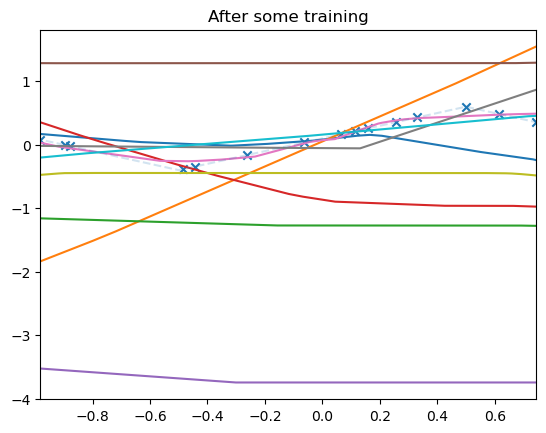

In [44]:
N_steps = 1000
xmin = np.min(dataset.inputs.detach().numpy())
xmax = np.max(dataset.inputs.detach().numpy())
plt.xlim(xmin, xmax)
print(xmin, xmax)

for i, model in enumerate(model_list):
    losses = train(
        model,
        dataset,
        N_steps=N_steps,
        batch_size=30,
        lr=0.001,
        save_weights_every=1,
    )
    all_losses[i] += losses
    plot_net(model, xmin=xmin, xmax=xmax)

plot_data(dataset)
plt.title("After some training")

plt.show()

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

axs[0].set_title("Train loss")
for i, losses in enumerate(all_losses):
    points = np.arange(0, len(losses), 1)
    losses = np.array(losses)
    axs[0].loglog(points, losses[points], alpha=0.5)

axs[1].set_title("Relative weight movement of last layer")
for model in model_list:
    all_weights1 = np.array(model.weight_history)
    weight_evol = np.linalg.norm(
        all_weights1 - all_weights1[0], axis=1
    ) / np.linalg.norm(all_weights1[0])

    axs[1].plot(weight_evol, alpha=0.5)

plt.show()

# Scaling

Now we attempt to enter the lazy regime by scaling the model outputs.

In [ ]:
n_points = 10

dataset = Data(n=n_points, xmin=-1, xmax=1, noise_level=0, type="middle")

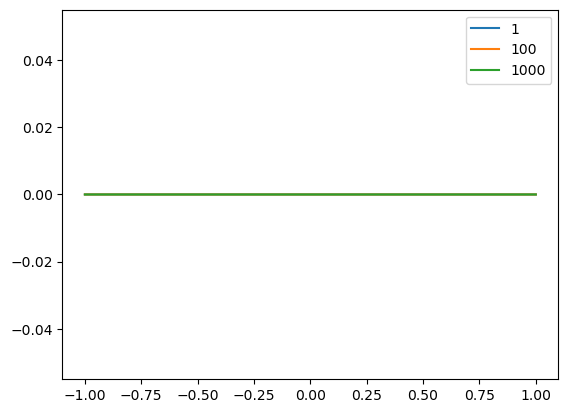

In [ ]:
class ScaledModel(MLPdeep):
    """ "
    From a base network, creates a scaled copy with 0 initialization. Keeps a frozen copy of a base model.

    alpha: scaling factor
    """

    def __init__(self, base_model, alpha=1):
        super().__init__(hidden_dim=base_model.hidden_dim)

        self.alpha = alpha
        self.load_state_dict(base_model.state_dict())

        self.base_model = [
            base_model
        ]  # trick to hide from the other parameters dictionary. Probably not the proper way to do this...

    def forward(self, x):
        """
        Scales the output and subtracts the initial function
        """
        with torch.no_grad():
            base = self.base_model[0].forward(x).detach()
        return self.alpha * (super().forward(x) - base)


base_model = MLPdeep(hidden_dim=8)

alphas = [1, 100, 1000]  # , 2000, 10000]
model_list = []

for alpha in alphas:
    new_model = ScaledModel(base_model, alpha=alpha)
    new_model.load_state_dict(base_model.state_dict())
    model_list.append(new_model)

    plot_net(new_model, label=f"{alpha}")

all_losses = [[] for _ in range(len(model_list))]

plt.legend()
plt.show()

In [ ]:
train(
    model_list[2],
    dataset,
    N_steps=10000,
    batch_size=n_points,
    lr=0.1 / alphas[2] ** 2,
    save_weights_every=1,
)

plot_data(dataset)
plt.legend()
plt.title("After some training")


for i, model in enumerate(model_list):
    plot_net(model, xmin=xmin, xmax=xmax, label=f"alpha = {alphas[i]}")

-1 1


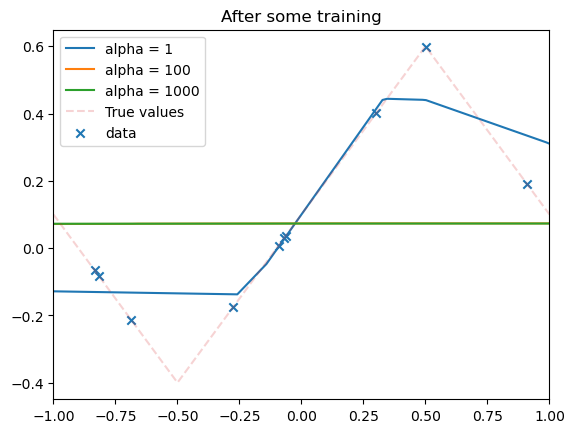

In [ ]:
N_steps = 10000
xmin = -1  # np.min(dataset.inputs.detach().numpy())
xmax = 1  # np.max(dataset.inputs.detach().numpy())
plt.xlim(xmin, xmax)
print(xmin, xmax)

for i, model in enumerate(model_list):
    losses = train(
        model,
        dataset,
        N_steps=N_steps,
        batch_size=n_points,
        lr=0.01 / alphas[i] ** 2,
        save_weights_every=1,
    )
    all_losses[i] += losses
    plot_net(model, xmin=xmin, xmax=xmax, label=f"alpha = {alphas[i]}")

plot_data(dataset)
plt.legend()
plt.title("After some training")

plt.show()

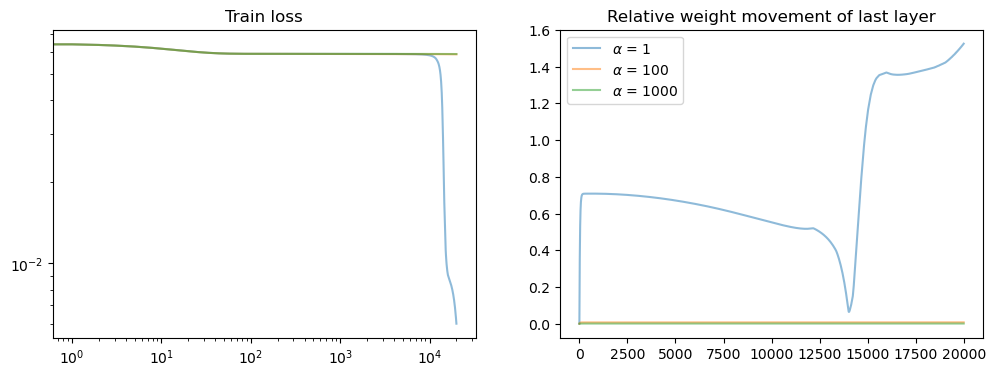

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

axs[0].set_title("Train loss")
for i, losses in enumerate(all_losses):
    points = np.arange(0, len(losses), 1)
    losses = np.array(losses)  # / alphas[i] ** 2
    axs[0].loglog(points, losses[points], alpha=0.5, label=f"{alphas[i]}")

axs[1].set_title("Relative weight movement of last layer")
for i, model in enumerate(model_list):
    all_weights1 = np.array(model.weight_history)
    weight_evol = np.linalg.norm(
        all_weights1 - all_weights1[0], axis=1
    ) / np.linalg.norm(all_weights1[0])

    axs[1].plot(weight_evol, alpha=0.5, label=rf"$\alpha$ = {alphas[i]}")

plt.legend()
plt.show()

## 5 - The effect of scaling on a 1D model 

**Question** Explain the piece of code below.

see blog post



In [ ]:
import numpy as np
import matplotlib.pyplot as plt

w_0 = 1.5


def f(x, w):
    return (
        w * x / 2 + np.log(1 + w**2) * x / 5 + 0.1 * np.sin(np.exp(2 * w))
    )  # np.exp(0.1*w))


def h(x, w, w_0=0.4):
    return f(x, w) * (w - w_0)


def linh(x, w, w_0=0.4):
    return f(x, w_0) * (w - w_0)


xys = [(1.5, 3)]


def l(w, alpha):
    return np.sum([(alpha * h(x, w, w_0=w_0) - y) ** 2 / 2 for x, y in xys]) / alpha**2


def linl(w, alpha):
    return (
        np.sum([(alpha * linh(x, w, w_0=w_0) - y) ** 2 / 2 for x, y in xys]) / alpha**2
    )


alphas = [1, 5, 10, 50, 100, 1000, 2000, 10000]

ws = np.linspace(-1, 1, 100)
plt.title("h(2; w)")
plt.plot(ws, [h(2, w, w_0=w_0) for w in ws])
plt.show()

for alpha in alphas:
    delta = 2 / alpha ** (3 / 4)
    ws = np.linspace(w_0 - delta, w_0 + delta, 5000)
    plt.title(f"Loss landscape of scaled model: alpha = {alpha}")
    plt.plot(ws, [l(w, alpha) for w in ws], label="Loss of scaled model")
    plt.plot(ws, [linl(w, alpha) for w in ws], label="Loss of scaled linearized model")
    plt.grid(alpha=0.2)
    plt.legend()
    plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

w_0 = 1.5


def f(x, w):
    return w * x / 2 + np.log(1 + w**2) * x / 5 + 0.1 * np.sin(np.exp(2 * w))


def h(x, w, w_0=0.4):
    return f(x, w) * (w - w_0)


def linh(x, w, w_0=0.4):
    return f(x, w_0) * (w - w_0)


xys = [(1.5, 3)]


def l(w, alpha):
    return np.sum([(alpha * h(x, w, w_0=w_0) - y) ** 2 / 2 for x, y in xys]) / alpha**2


def linl(w, alpha):
    return (
        np.sum([(alpha * linh(x, w, w_0=w_0) - y) ** 2 / 2 for x, y in xys]) / alpha**2
    )


alphas = [1, 5, 10, 50, 100, 1000, 2000, 10000]

for alpha in alphas:
    delta = 2 / alpha ** (3 / 4)
    ws = np.linspace(w_0 - delta, w_0 + delta, 5000)
    plt.title(f"??: alpha = {alpha}")
    plt.plot(ws, [l(w, alpha) for w in ws], label="??")
    plt.plot(ws, [linl(w, alpha) for w in ws], label="??")
    plt.grid(alpha=0.2)
    plt.legend()
    plt.show()

## Pieces

In [ ]:
mlp = model_list[0]

for name, param in mlp.named_parameters():
    print(name)
    print(param.shape)
    print(np.linalg.norm((param.detach().numpy())))

In [ ]:
a = np.arange(10, 30)
shifted_a = np.zeros(20)
print(shifted_a)
shifted_a[1:] = a[:-1]
print(shifted_a)
print(a)

evol = (a - shifted_a)[1:] / a[1:]
print(evol)

In [ ]:
plt.title("Difference in succesive weights")
for model in model_list:
    all_weights1 = np.array(model.weight_history)
    shifted_weights = np.zeros(all_weights1.shape)
    shifted_weights[1:, :] = all_weights1[:-1, :]
    weight_evol = np.linalg.norm(
        (all_weights1 - shifted_weights)[1:], axis=1
    ) / np.linalg.norm(all_weights1[1:], axis=1)

    plt.plot(weight_evol, alpha=0.5)


plt.show()

You can use the following code snippet to save your network.

In [ ]:
# mlp = MLPdeep() # MLPshallow()
# PATH = f'./{dataset.type}_{mlp.net_type}.pth'
# torch.save(mlp.state_dict(), PATH)

# net = MLPdeep() # MLPshallow()
# net.load_state_dict(torch.load(PATH))

1.2872850938240181


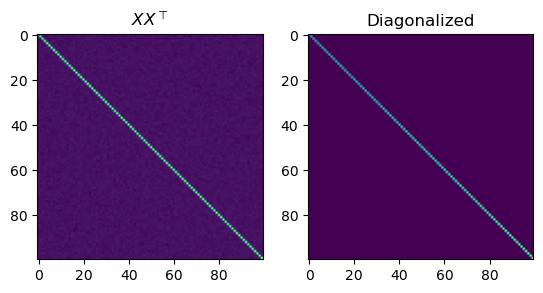

100


In [ ]:
p = 100
n = 5000

X = np.random.normal(size=(p, n)) / np.sqrt(n)
Y = np.random.normal(size=(n, 1))

XXt = X @ X.transpose()
XY = X @ Y

fig, axs = plt.subplots(1, 2)

axs[0].set_title(r"$X X^\top $")
axs[0].imshow(XXt)

eigvals, P = np.linalg.eigh(XXt)
print(max(eigvals))

axs[1].set_title("Diagonalized")
axs[1].imshow(P.transpose() @ XXt @ P)
plt.show()

print(np.linalg.matrix_rank(X))

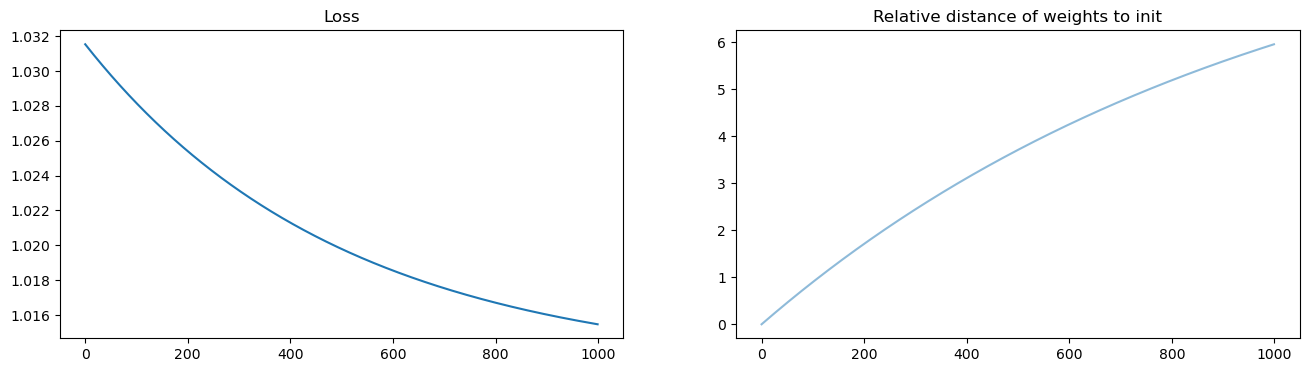

In [ ]:
T = 1000
eta = 0.001

ws = np.zeros((T, p, 1))
w = np.random.normal(size=(p, 1)) / np.sqrt(p)

losses = []
for t in range(T):
    w = w - eta * XXt @ w + eta * XY
    ws[t] = w

    losses.append(np.linalg.norm(X.transpose() @ w - Y) ** 2 / n)

ws = ws.squeeze(axis=2)
fig, axs = plt.subplots(1, 2, figsize=(16, 4))

axs[0].set_title("Loss")
axs[0].plot(losses)


axs[1].set_title("Relative distance of weights to init")
weight_evol = np.linalg.norm(ws - ws[0, :], axis=1) / np.linalg.norm(ws[0, :])
axs[1].plot(weight_evol, alpha=0.5)


plt.show()

# In the right basis, most coordinates of w dont move

w only moves in a low dimensional subspace: the image of X

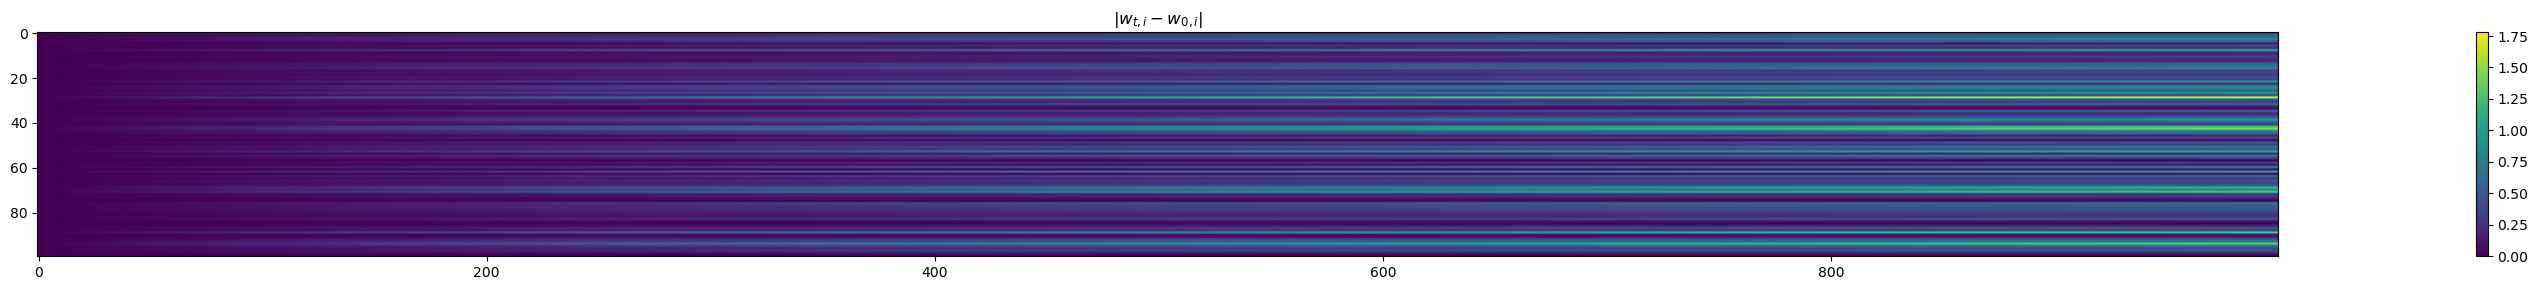

In [ ]:
fig, ax = plt.subplots(figsize=(40, 3))

plt.title(r"$|w_{t, i} - w_{0, i}|$")
ws_in_base = ws @ P

a = ax.imshow(np.abs((ws_in_base - ws_in_base[0]).transpose()))
fig.colorbar(a)
plt.tight_layout()
plt.show()

Bias complexity tradeoff

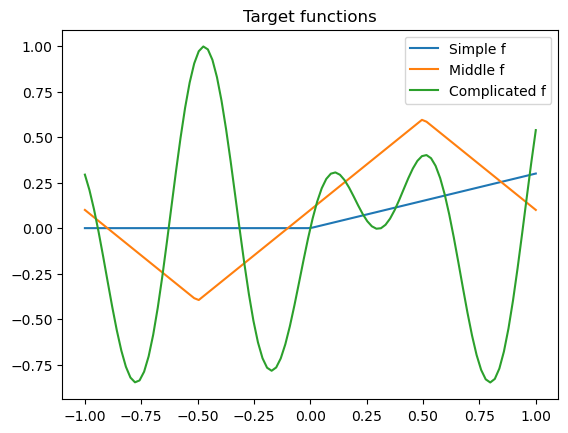

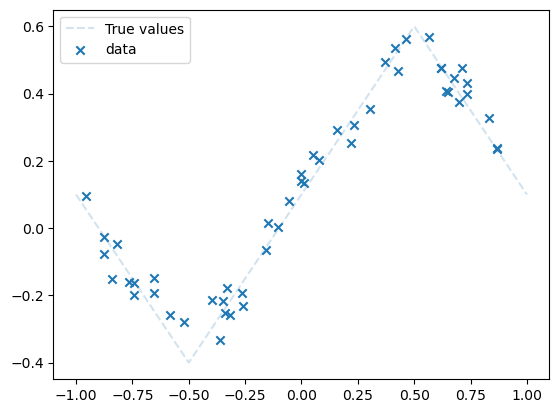

In [ ]:
xs = np.linspace(-1, 1, 100)
plt.plot(xs, simple_f(xs), label="Simple f")
plt.plot(xs, middle_f(xs), label="Middle f")
plt.plot(xs, complex_f(xs), label="Complicated f")
plt.title("Target functions")
plt.legend()
plt.show()

npoints = 50

dataset = Data(n=npoints, xmin=-1, xmax=1, noise_level=0.05, type="middle")

plot_data(dataset)
plt.legend()
plt.show()

In [ ]:
class LinSin(nn.Module):
    """
    A linear model with sinusoidal features. Assumes feature_dim is even.
    """

    def __init__(self, feature_dim):
        super().__init__()
        self.feature_dim = feature_dim
        self.lout = nn.Linear(self.feature_dim, 1)

        self.weight_history = []

    def phi(self, x):
        """
        Computes $sin(2\pi k x), cos(2\pi k x) $ for k in $[feature_dim / 2]$
        """
        r = 0.2 * np.pi * torch.arange(int(self.feature_dim / 2)) * x
        return torch.concatenate([torch.sin(r), torch.cos(r)], axis=1)

    def save_weights(self):
        with torch.no_grad():
            l = list(self.parameters())
            self.weight_history.append(np.copy(l[-1].numpy()))

    def forward(self, x):
        return self.lout(self.phi(x))

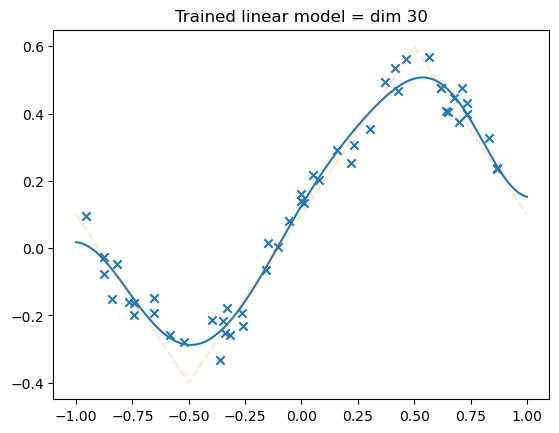

tensor(0.0026)


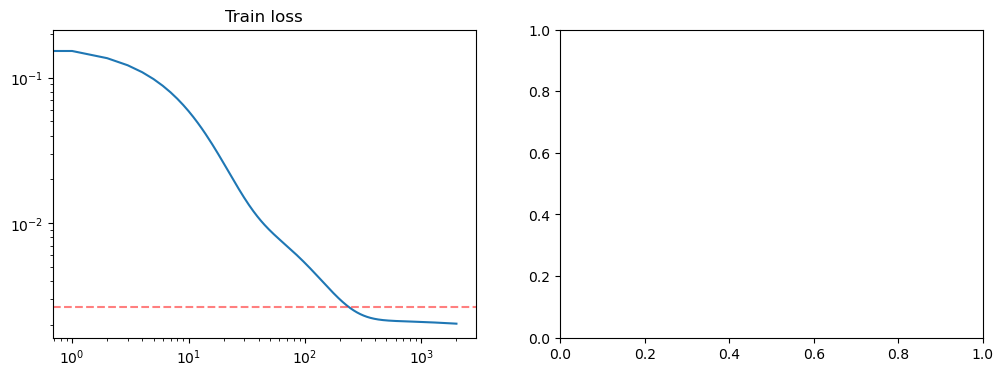

In [ ]:
model = LinSin(feature_dim=30)
losses = train(
    model,
    dataset,
    N_steps=2000,
    batch_size=npoints,
    lr=0.01,
    save_weights_every=-1,
)

plot_net(model)
plot_data(dataset)
plt.title("Trained linear model = dim 30")
plt.show()

fig, axs = plt.subplots(1, 2, figsize=(12, 4))
axs[0].loglog(losses)
axs[0].set_title("Train loss")
true_risk = dataset.risk(model)
print(true_risk)
axs[0].axhline(true_risk, color="red", alpha=0.5, linestyle="--")


plt.show()

In [ ]:
# train_losses = []
# var_train = []
# risks = []
dimensions = np.array(list(range(150, 200, 2)))  # + list(range(100, 300, 2)))
for dim in dimensions:
    losses = []
    local_risks = []
    for _ in range(10):
        model = LinSin(feature_dim=dim)
        losses.append(
            train(
                model,
                dataset,
                N_steps=1000,
                batch_size=100,
                lr=0.1,
                save_weights_every=-1,
            )[-1]
        )
        local_risks.append(dataset.risk(model).detach())
    train_losses.append(np.mean(losses))
    var_train.append(np.var(losses))
    risks.append(np.mean(local_risks))


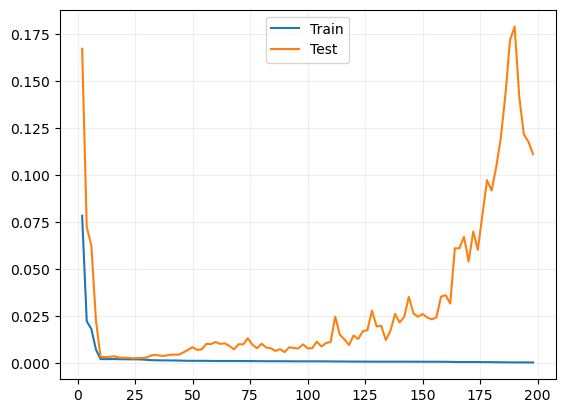

In [ ]:
plt.grid(alpha=0.2)

plt.plot(np.arange(2, 200, 2), train_losses, label="Train")
plt.plot(np.arange(2, 200, 2), risks, label="Test")
plt.legend()

Gradient flow and Gradient descent

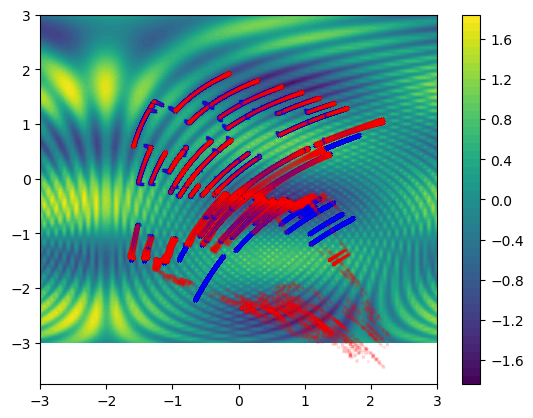

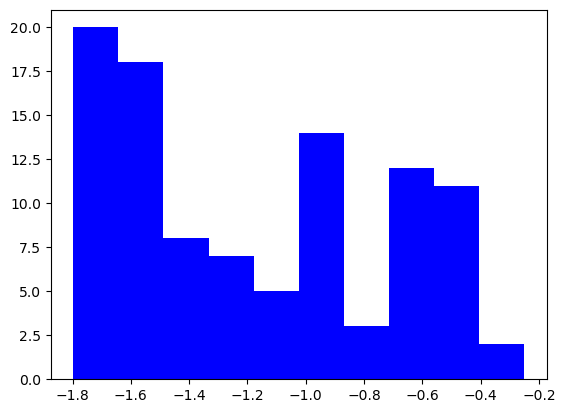

(array([ 9.,  8.,  7., 24., 22.,  4., 15.,  5.,  3.,  3.]),
 array([-1.79505253, -1.61360693, -1.43216133, -1.25071573, -1.06927013,
        -0.88782459, -0.706379  , -0.5249334 , -0.34348783, -0.16204225,
         0.01940334]),
 <BarContainer object of 10 artists>)

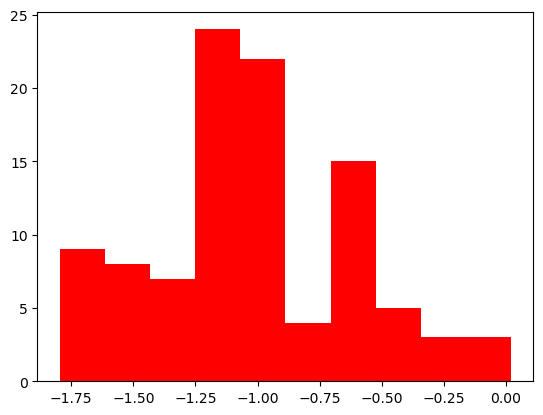

In [ ]:
T = 10000
lrsmall = 0.0001
lrbig = 0.002
N = 100


with torch.no_grad():
    xs = torch.linspace(-3, 3, 100)
    ys = torch.linspace(-3, 3, 100)

    xx, yy = torch.meshgrid(xs, ys, indexing="xy")
    plt.contourf(xs, ys, f(xx, yy), levels=50)
    plt.colorbar()

finalvals_small = []
finalvals_big = []

for i in range(N):
    w0 = 3 * (torch.rand(2) - 0.5)
    w0prime = w0.detach().clone()
    wsmall = W(w0=w0)
    wbig = W(w0=w0prime)
    weights_small = []
    weights_big = []

    opt_small = optim.SGD(wsmall.parameters(), lr=lrsmall)
    opt_big = optim.SGD(wbig.parameters(), lr=lrbig)
    for _ in range(T):
        opt_small.zero_grad()
        wsmall().backward()
        opt_small.step()

        opt_big.zero_grad()
        wbig().backward()
        opt_big.step()

        with torch.no_grad():
            weights_small.append(np.copy(wsmall.param))
            weights_big.append(np.copy(wbig.param))

    finalvals_small.append(wsmall().detach())
    finalvals_big.append(wbig().detach())

    plt.plot(
        [w[0] for w in weights_small],
        [w[1] for w in weights_small],
        "x",
        alpha=0.1,
        markersize=2,
        label=i,
        color="blue",
    )

    plt.plot(
        [w[0] for w in weights_big],
        [w[1] for w in weights_big],
        "x",
        alpha=0.1,
        markersize=2,
        label=i,
        color="red",
    )
plt.show()

plt.hist(finalvals_small, color="blue")
plt.show()
plt.hist(finalvals_big, color="red")

In [ ]:
def f(x, y):
    return torch.sin(x + 4) * (torch.cos(3 * y - 5) + 0.3) + 0.5 * torch.cos(
        2 * (x + 2) * (y - 4) ** 2
    )


class W(nn.Module):
    def __init__(self, w0=None):
        super().__init__()
        if w0 is None:
            w0 = 3 * (torch.rand(2) - 0.5)
        self.param = nn.Parameter(w0)

    def forward(self):
        e0 = torch.tensor([1.0, 0.0])
        e1 = torch.tensor([0.0, 1.0])
        return f(e0 @ self.param, e1 @ self.param)